# Setup

## Imports

In [1]:
import re
import glob
import random
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import nltk.collocations as co_loc
from scipy.spatial.distance import jensenshannon
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

## Functions and Utility Stuff

In [2]:
stop_words = set(nltk.corpus.stopwords.words("english")) | set(["subject"])
puncs = set([",", ".", "@", "#", "%", "^", "&", "*", "(", ")", "_", "-", "=", "+", "{", "}", "[", "]",
             ":", ";", "'" '"', "<", ">", "?"])

# Model Evaluation
def get_full_cross_validation_eval_metrics(num_folds, featuresets):
    accuracy_list = []
    reference = []
    hypothesis = []
    subset_size = int(len(featuresets) / 10)
    for i in range(num_folds):
        round_test = featuresets[(i * subset_size):][:subset_size]
        round_train = featuresets[:(i * subset_size)] + featuresets[((i + 1) * subset_size):]
        clf = nltk.NaiveBayesClassifier.train(round_train)
        correct = 0
        for case in round_test:
            features = case[0]
            label = case[1]; reference.append(label)
            pred = clf.classify(features); hypothesis.append(pred)
            if label == pred:
                correct += 1
        accuracy = float(correct) / float(len(round_test))
        accuracy_list.append(accuracy)
        print("Accuracy for Fold {}: {}".format(i, accuracy))
    print("---Average Accuracy: {}---".format(mean(accuracy_list)))
    labels = set(reference)
    recall_list = []
    precision_list = []
    F1_list = []
    unable_to_calc = False
    for label in labels:
        TP = FP = FN = TN = 0
        for i, val in enumerate(reference):
            if val == label and hypothesis[i] == label: TP += 1
            elif val == label and hypothesis[i] != label: FN += 1
            elif val != label and hypothesis[i] == label: FP += 1
            #elif val != label and hypothesis[i] != label: TN += 1
            else: TN += 1
        try:
            recall = TP / (TP + FP)
            precision = TP / (TP + FN)
            recall_list.append(recall)
            precision_list.append(precision)
            F1_list.append(2 * (recall * precision) / (recall + precision))
        except ZeroDivisionError:
            unable_to_calc = True
    print("\n\tPrecision\tRecall\t\tF1")
    if not unable_to_calc:
        for i, label in enumerate(labels):
            print("{}\t{}\t\t{}\t\t{}".format(label, round(precision_list[i], 3),
                                              round(recall_list[i], 3), round(F1_list[i], 3)))
    print("\n")
    print(nltk.ConfusionMatrix(reference, hypothesis).pretty_format(sort_by_count=True))
    print(nltk.ConfusionMatrix(reference, hypothesis).pretty_format(sort_by_count=True, show_percents=True))

# SKLearn Model Evaluation
def get_sklearn_model_evaluation_metrics(reference, hypothesis):
    labels = set(reference)
    recall_list = []
    precision_list = []
    F1_list = []
    correct = 0
    for label in labels:
        TP= FP = FN = TN = 0
        for i, val in enumerate(reference):
            if val == label and hypothesis[i] == label:
                TP += 1
                correct == 1
            elif val == label and hypothesis[i] != label: FN += 1
            elif val != label and hypothesis[i] == label: FP += 1
            else:
                TN += 1
                correct += 1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append(2 * (recall * precision) / (recall + precision))
    print("Accuracy: {}".format(round(float(correct) / float(len(reference)), 3)))
    print("\n\tPrecision\tRecall\t\tF1")
    for i, label in enumerate(labels):
        print("{}\t{}\t\t{}\t\t{}".format(label, round(precision_list[i], 3),
                                          round(recall_list[i], 3), round(F1_list[i], 3)))
    print()
    print(confusion_matrix(reference, hypothesis))

# Unigram Bag of Words
def get_bow_representation(email, word_features, use_bool=True):
    email_words = email
    features = {}
    for word in word_features:
        if use_bool:
            features[word] = (word in set(email_words))
        else:
            features[word] = email_words.count(word)
    return features

# Bigram Bag of Words
def get_bigram_bow_representation(email, bigram_features, use_bool=True):
    email_bigrams = [" ".join(bigram) for bigram in ngrams(email, 2)]
    features = {}
    for bigram in bigram_features:
        if use_bool:
            features[bigram] = (bigram in set(email_bigrams))
        else:
            features[bigram] = email_bigrams.count(bigram)
    return features

# Get top N word in a frequence distribution
def get_word_features(emails, n):
    all_words_list = []
    for email in emails:
        all_words_list.extend(email[0])
    all_words = nltk.FreqDist(all_words_list)
    word_items = all_words.most_common(n)
    word_features = [word for (word, count) in word_items]
    return word_features

# Get punctuation features
def get_punctuation_features(emaildocs):
    punctuation_list = set()
    for email in emaildocs:
        for tok in email[0]:
            if len(re.findall(r"\w", tok)) == 0:
                punctuation_list.add(tok)
    return punctuation_list

# Apply Tokenization to Spam and Ham, combine, and return
def get_emaildocs(spamtexts, hamtexts, tokenizer):
    emaildocs = []
    for spam in spamtexts:
        emaildocs.append((tokenizer(spam), "spam"))
    for ham in hamtexts:
        emaildocs.append((tokenizer(ham), "ham"))
    random.seed(5)
    random.shuffle(emaildocs)
    return emaildocs

# Remove Stop Words
def remove_stopwords(emaildocs, stop_words):
    final_emails = []
    for email in emaildocs:
        final_emails.append(([tok for tok in email[0] if tok not in stop_words], email[1]))
    random.seed(5)
    random.shuffle(final_emails)
    return final_emails

# Custom Tokenizer
def custom_tokenizer(email):
    tokenizer_pattern = r'''(?x)
                        [a-z]+(?:['\-][a-z]+)+
                        |[a-z]+
                        |\$\d+
                     '''
    return nltk.regexp_tokenize(email.lower().replace(" ' ", "'").replace("$ ", "$").replace(" - ", "-"), tokenizer_pattern)

# Use NLTK's Tokenizer, Joining Dollar Sign to Following Token
def tokenize_with_dollars(email):
    return nltk.word_tokenize(email.lower().replace("$ ", "$"))

# Tokenize and Stem
def tokenize_and_stem(email):
    stemmer = nltk.PorterStemmer()
    return [stemmer.stem(tok) for tok in nltk.word_tokenize(email)]

# Convert NLTK Features to Pandas DataFrame for SKlearn
def convert_nltk_features_to_df(features):
    pos_neg_map = {"spam": 1, "ham": 0}
    first_pass = True
    df = None
    for feats in features:
        if first_pass:
            df = {feat: [] for feat in feats[0].keys()}
            df["label"] = []
            first_pass = False
        df["label"].append(pos_neg_map[feats[1]])
        for feat, val in feats[0].items():
            df[feat].append(val)
    return pd.DataFrame(df)

## Load in emails

In [3]:
hamtexts = []
spamtexts = []

for file in glob.glob("corpus/*/*.txt"):
    with open(file, "r", encoding="latin-1") as _f:
        if file.endswith("ham.txt"):
            hamtexts.append(_f.read())
        else:
            spamtexts.append(_f.read())

### Get an idea of counts per class

In [4]:
print("Number of spam files: {}\n"\
      "Number of ham files:  {}".format(len(spamtexts), len(hamtexts)))

Number of spam files: 1500
Number of ham files:  3672


### Classes are unbalanced, so reducing hamtexts down to the number of spamtexts

In [5]:
random.seed(5)
hamtexts = random.sample(hamtexts, len(spamtexts))
print("New number of spam files: {}\n"\
      "New number of ham files:  {}".format(len(spamtexts), len(hamtexts)))

New number of spam files: 1500
New number of ham files:  1500


### Taking a look at the token distribution differences

#### Using NLTK builtin tokenizer

In [6]:
ham_words = [tok for email in hamtexts for tok in nltk.word_tokenize(email)]
spam_words = [tok for email in spamtexts for tok in nltk.word_tokenize(email)]

In [7]:
ham_dist = nltk.FreqDist(ham_words)
spam_dist = nltk.FreqDist(spam_words)

ham_most_common_counts = ham_dist.most_common(500)
ham_most_common = set([entry[0] for entry in ham_most_common_counts])
spam_most_common_counts = spam_dist.most_common(500)
spam_most_common = set([entry[0] for entry in spam_most_common_counts])

spam_minus_ham = spam_most_common - ham_most_common
ham_minus_spam = ham_most_common - spam_most_common
in_common = ham_most_common.intersection(spam_most_common)

print("Count diff spam - ham: {}".format(len(spam_most_common)))
print("Count diff ham - spam: {}".format(len(ham_minus_spam)))
print("Count in common: {}".format(len(in_common)))


Count diff spam - ham: 500
Count diff ham - spam: 246
Count in common: 254


#### Top 15 tokens in both classes

In [8]:
print("ham\t\t\tspam")
for i in range(len(ham_most_common_counts)):
    if i > 14:
        break
    print("{}\t\t{}".format(ham_most_common_counts[i], spam_most_common_counts[i]))

ham			spam
('-', 31194)		('.', 19517)
('/', 15806)		(',', 11251)
('.', 13873)		('-', 7942)
(',', 12634)		('the', 7297)
(':', 9861)		(':', 6114)
('the', 7728)		('/', 5707)
('to', 6232)		('to', 5173)
('ect', 6017)		('and', 4917)
('@', 4681)		('of', 4511)
('for', 3347)		('?', 4107)
('>', 3262)		('a', 3794)
('and', 3248)		('in', 3147)
('hou', 3143)		('=', 3091)
('enron', 2706)		('you', 2797)
('a', 2490)		('for', 2526)


#### Unique token counts for both classes

In [9]:
ham_words_uniq = set(ham_words)
spam_words_uniq = set(spam_words)

print("Unique Ham Tokens: {}".format(len(ham_words_uniq)))
print("Unique Spam Tokens: {}".format(len(spam_words_uniq)))
print("Total Unique Tokens: {}".format(len(ham_words_uniq | spam_words_uniq)))

Unique Ham Tokens: 12780
Unique Spam Tokens: 38799
Total Unique Tokens: 44914


#### Taking a look at puncutation usage differences

C:\Users\Christopher DiPersio\.conda\envs\datasci_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 1 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Christopher DiPersio\.conda\envs\datasci_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 1 missing from current font.
  font.set_text(s, 0, flags=flags)


Jensen-Shannon Distance for Punctuation: 0.3084759354925819


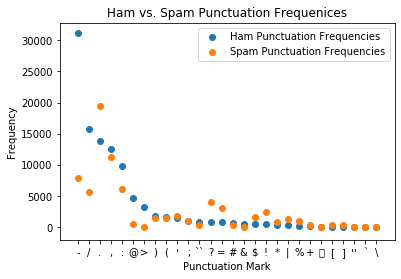

In [10]:
punc_counts = {}
for entry in ham_most_common_counts:
    tok, count = entry
    if not re.match(r"\w", tok):
        if tok not in punc_counts:
            punc_counts[tok] = {"ham": 0, "spam": 0}
        punc_counts[tok]["ham"] += count
for entry in spam_most_common_counts:
    tok, count = entry
    if not re.match(r"\w", tok):
        if tok not in punc_counts:
            punc_counts[tok] = {"ham": 0, "spam": 0}
        punc_counts[tok]["spam"] += count
punc_counts_df = {"punctuation": [], "ham": [], "spam": []}
for punc, counts in punc_counts.items():
    punc_counts_df["punctuation"].append(punc)
    punc_counts_df["ham"].append(counts["ham"])
    punc_counts_df["spam"].append(counts["spam"])
punc_counts_df = pd.DataFrame(punc_counts_df)

plt.scatter(punc_counts_df["punctuation"], punc_counts_df["ham"], label="Ham Punctuation Frequencies")
plt.scatter(punc_counts_df["punctuation"], punc_counts_df["spam"], label="Spam Punctuation Frequencies")
plt.legend(loc='upper right')
plt.xlabel("Punctuation Mark")
plt.ylabel("Frequency")
plt.title("Ham vs. Spam Punctuation Frequenices")
#plt.show()
plt.savefig("ham_vs_spam_punc_freqs.png")

punc_probs = {"ham": [], "spam": []}
total_ham = sum(punc_counts_df["ham"].tolist())
total_spam = sum(punc_counts_df["spam"].tolist())
for index, row in punc_counts_df.iterrows():
    punc_probs["ham"].append(row["ham"] / total_ham)
    punc_probs["spam"].append(row["spam"] / total_spam)
print("Jensen-Shannon Distance for Punctuation: {}".format(jensenshannon(punc_probs["ham"], punc_probs["spam"])))

#### Taking a look at stop word usage differences

##### Top 500 tokens

Jensen-Shannon Distance for Stop Words (500 tokens): 0.19120547363769996


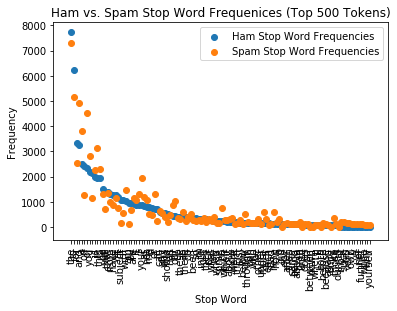

In [11]:
ham_dist = nltk.FreqDist(ham_words)
spam_dist = nltk.FreqDist(spam_words)

ham_most_common_counts = ham_dist.most_common(500)
ham_most_common = set([entry[0] for entry in ham_most_common_counts])
spam_most_common_counts = spam_dist.most_common(500)
spam_most_common = set([entry[0] for entry in spam_most_common_counts])

stop_word_counts = {}
for entry in ham_most_common_counts:
    tok, count = entry
    if tok in stop_words:
        if tok not in stop_word_counts:
            stop_word_counts[tok] = {"ham": 0, "spam": 0}
        stop_word_counts[tok]["ham"] += count
for entry in spam_most_common_counts:
    tok, count = entry
    if tok in stop_words:
        if tok not in stop_word_counts:
            stop_word_counts[tok] = {"ham": 0, "spam": 0}
        stop_word_counts[tok]["spam"] += count
stop_word_counts_df = {"stop word": [], "ham": [], "spam": []}
for sw, counts in stop_word_counts.items():
    stop_word_counts_df["stop word"].append(sw)
    stop_word_counts_df["ham"].append(counts["ham"])
    stop_word_counts_df["spam"].append(counts["spam"])
stop_word_counts_df = pd.DataFrame(stop_word_counts_df)

plt.scatter(stop_word_counts_df["stop word"], stop_word_counts_df["ham"], label="Ham Stop Word Frequencies")
plt.scatter(stop_word_counts_df["stop word"], stop_word_counts_df["spam"], label="Spam Stop Word Frequencies")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.xlabel("Stop Word")
plt.ylabel("Frequency")
plt.title("Ham vs. Spam Stop Word Frequenices (Top 500 Tokens)")
#plt.show()
plt.savefig("ham_vs_spam_stop_word_freqs_500.png")

stop_word_probs = {"ham": [], "spam": []}
total_ham = sum(stop_word_counts_df["ham"].tolist())
total_spam = sum(stop_word_counts_df["spam"].tolist())
for index, row in stop_word_counts_df.iterrows():
    stop_word_probs["ham"].append(row["ham"] / total_ham)
    stop_word_probs["spam"].append(row["spam"] / total_spam)
print("Jensen-Shannon Distance for Stop Words (500 tokens): {}".format(jensenshannon(stop_word_probs["ham"],
                                                                                     stop_word_probs["spam"])))

##### Top 100 tokens

Jensen-Shannon Distance for Stop Words (100 tokens): 0.26842505932885247


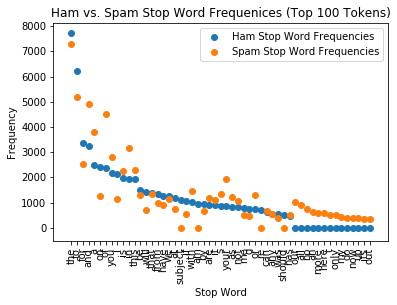

In [12]:
ham_dist = nltk.FreqDist(ham_words)
spam_dist = nltk.FreqDist(spam_words)

ham_most_common_counts = ham_dist.most_common(100)
ham_most_common = set([entry[0] for entry in ham_most_common_counts])
spam_most_common_counts = spam_dist.most_common(100)
spam_most_common = set([entry[0] for entry in spam_most_common_counts])

stop_words = set(nltk.corpus.stopwords.words("english")) | set(["subject"])

stop_word_counts = {}
for entry in ham_most_common_counts:
    tok, count = entry
    if tok in stop_words:
        if tok not in stop_word_counts:
            stop_word_counts[tok] = {"ham": 0, "spam": 0}
        stop_word_counts[tok]["ham"] += count
for entry in spam_most_common_counts:
    tok, count = entry
    if tok in stop_words:
        if tok not in stop_word_counts:
            stop_word_counts[tok] = {"ham": 0, "spam": 0}
        stop_word_counts[tok]["spam"] += count
stop_word_counts_df = {"stop word": [], "ham": [], "spam": []}
for sw, counts in stop_word_counts.items():
    stop_word_counts_df["stop word"].append(sw)
    stop_word_counts_df["ham"].append(counts["ham"])
    stop_word_counts_df["spam"].append(counts["spam"])
stop_word_counts_df = pd.DataFrame(stop_word_counts_df)

plt.scatter(stop_word_counts_df["stop word"], stop_word_counts_df["ham"], label="Ham Stop Word Frequencies")
plt.scatter(stop_word_counts_df["stop word"], stop_word_counts_df["spam"], label="Spam Stop Word Frequencies")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.xlabel("Stop Word")
plt.ylabel("Frequency")
plt.title("Ham vs. Spam Stop Word Frequenices (Top 100 Tokens)")
#plt.show()
plt.savefig("ham_vs_spam_stop_word_freqs_200.png")

stop_word_probs = {"ham": [], "spam": []}
total_ham = sum(stop_word_counts_df["ham"].tolist())
total_spam = sum(stop_word_counts_df["spam"].tolist())
for index, row in stop_word_counts_df.iterrows():
    stop_word_probs["ham"].append(row["ham"] / total_ham)
    stop_word_probs["spam"].append(row["spam"] / total_spam)
print("Jensen-Shannon Distance for Stop Words (100 tokens): {}".format(jensenshannon(stop_word_probs["ham"],
                                                                                     stop_word_probs["spam"])))

#### Taking a look at word frequency differences

In [13]:
emaildocs = get_emaildocs(spamtexts, hamtexts, nltk.word_tokenize)
word_freqs_per_doc = {"ham": {}, "spam": {}}
all_toks = set()
for email in emaildocs:
    email_text, label = email
    email_toks = set(email_text)
    for tok in email_toks:
        all_toks.add(tok)
        if tok not in word_freqs_per_doc[label]:
            word_freqs_per_doc[label][tok] = []
        word_freqs_per_doc[label][tok].append(email_text.count(tok))

ave_word_freqs_per_doc_df = {"tok": [], "ham": [], "spam": []}
for tok in all_toks:
    ave_word_freqs_per_doc_df["tok"].append(tok)
    for label in ["ham", "spam"]:
        if tok in word_freqs_per_doc[label]:
            ave_word_freqs_per_doc_df[label].append(mean(word_freqs_per_doc[label][tok]))
        else:
            ave_word_freqs_per_doc_df[label].append(0)
ave_word_freqs_per_doc_df = pd.DataFrame(ave_word_freqs_per_doc_df)

print("Ham Max: {}".format(ave_word_freqs_per_doc_df["ham"].max()))
print("Ham Min: {}".format(ave_word_freqs_per_doc_df["spam"].min()))
print("Ham Quartiles:\n{}".format(ave_word_freqs_per_doc_df["ham"].quantile([0.25, 0.5, 0.72, 0.75, 1.0])))
print()
print("Spam Max: {}".format(ave_word_freqs_per_doc_df["spam"].max()))
print("Spam Min: {}".format(ave_word_freqs_per_doc_df["spam"].min()))
print("Spam Quartiles:\n{}".format(ave_word_freqs_per_doc_df["spam"].quantile([0.14, 0.25, 0.5, 0.75, 0.88, 1.0])))

Ham Max: 56.0
Ham Min: 0.0
Ham Quartiles:
0.25     0.0
0.50     0.0
0.72     1.0
0.75     1.0
1.00    56.0
Name: ham, dtype: float64

Spam Max: 73.0
Spam Min: 0.0
Spam Quartiles:
0.14     1.000000
0.25     1.000000
0.50     1.000000
0.75     1.000000
0.88     1.073329
1.00    73.000000
Name: spam, dtype: float64


# Getting Baseline Using NLTK's Builtin Tokenizer and 2k Features

In [14]:
emaildocs = get_emaildocs(spamtexts, hamtexts, nltk.word_tokenize)
word_features = get_word_features(emaildocs, 2000)
bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.96
Accuracy for Fold 1: 0.9633333333333334
Accuracy for Fold 2: 0.9566666666666667
Accuracy for Fold 3: 0.9433333333333334
Accuracy for Fold 4: 0.9766666666666667
Accuracy for Fold 5: 0.9666666666666667
Accuracy for Fold 6: 0.9433333333333334
Accuracy for Fold 7: 0.9633333333333334
Accuracy for Fold 8: 0.9666666666666667
Accuracy for Fold 9: 0.9733333333333334
---Average Accuracy: 0.9613333333333334---

	Precision	Recall		F1
spam	0.997		0.931		0.963
ham	0.926		0.996		0.96


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1389> 111 |
spam |    5<1495>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.3%>  3.7% |
spam |   0.2% <49.8%>|
-----+---------------+
(row = reference; col = test)



# Experiments

## Different Vocab Sizes on the Baseline Model

In [15]:
for n in [500, 1000, 1500, 3000, 5000, 7500, 10000]:
    print("\n=====Results for vocab size {}=====".format(n))
    word_features = get_word_features(emaildocs, n)
    bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in emaildocs]
    get_full_cross_validation_eval_metrics(10, bow_features)


=====Results for vocab size 500=====
Accuracy for Fold 0: 0.9333333333333333
Accuracy for Fold 1: 0.95
Accuracy for Fold 2: 0.9366666666666666
Accuracy for Fold 3: 0.9166666666666666
Accuracy for Fold 4: 0.96
Accuracy for Fold 5: 0.9366666666666666
Accuracy for Fold 6: 0.91
Accuracy for Fold 7: 0.9566666666666667
Accuracy for Fold 8: 0.94
Accuracy for Fold 9: 0.9666666666666667
---Average Accuracy: 0.9406666666666667---

	Precision	Recall		F1
spam	0.999		0.895		0.944
ham	0.883		0.998		0.937


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1324> 176 |
spam |    2<1498>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <44.1%>  5.9% |
spam |   0.1% <49.9%>|
-----+---------------+
(row = reference; col = test)


=====Results for vocab size 1000=====
Accuracy for Fold 0: 0.9566666666666667
Accuracy for Fold 1: 0.9

## Custom Tokenization

In [16]:
emaildocs = get_emaildocs(spamtexts, hamtexts, custom_tokenizer)
word_features = get_word_features(emaildocs, 3000)
bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.9366666666666666
Accuracy for Fold 1: 0.9266666666666666
Accuracy for Fold 2: 0.9166666666666666
Accuracy for Fold 3: 0.9033333333333333
Accuracy for Fold 4: 0.9366666666666666
Accuracy for Fold 5: 0.89
Accuracy for Fold 6: 0.92
Accuracy for Fold 7: 0.9233333333333333
Accuracy for Fold 8: 0.93
Accuracy for Fold 9: 0.9533333333333334
---Average Accuracy: 0.9236666666666666---

	Precision	Recall		F1
spam	0.907		0.939		0.922
ham	0.941		0.91		0.925


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1411>  89 |
spam |  140<1360>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <47.0%>  3.0% |
spam |   4.7% <45.3%>|
-----+---------------+
(row = reference; col = test)



## Custom Tokenization & Stop Word Removal

In [17]:
emaildocs = remove_stopwords(emaildocs, stop_words)
word_features = get_word_features(emaildocs, 3000)
bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.95
Accuracy for Fold 1: 0.9
Accuracy for Fold 2: 0.89
Accuracy for Fold 3: 0.8966666666666666
Accuracy for Fold 4: 0.91
Accuracy for Fold 5: 0.8933333333333333
Accuracy for Fold 6: 0.91
Accuracy for Fold 7: 0.9266666666666666
Accuracy for Fold 8: 0.83
Accuracy for Fold 9: 0.93
---Average Accuracy: 0.9036666666666666---

	Precision	Recall		F1
spam	0.865		0.937		0.9
ham	0.942		0.875		0.907


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1413>  87 |
spam |  202<1298>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <47.1%>  2.9% |
spam |   6.7% <43.3%>|
-----+---------------+
(row = reference; col = test)



## Standard Tokenization & Joining Dollars To Number

In [18]:
emaildocs = get_emaildocs(spamtexts, hamtexts, tokenize_with_dollars)
word_features = get_word_features(emaildocs, 3000)
bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.9766666666666667
Accuracy for Fold 1: 0.9633333333333334
Accuracy for Fold 2: 0.9533333333333334
Accuracy for Fold 3: 0.95
Accuracy for Fold 4: 0.98
Accuracy for Fold 5: 0.96
Accuracy for Fold 6: 0.95
Accuracy for Fold 7: 0.9633333333333334
Accuracy for Fold 8: 0.96
Accuracy for Fold 9: 0.9766666666666667
---Average Accuracy: 0.9633333333333334---

	Precision	Recall		F1
spam	0.989		0.94		0.964
ham	0.937		0.989		0.962


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1406>  94 |
spam |   16<1484>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.9%>  3.1% |
spam |   0.5% <49.5%>|
-----+---------------+
(row = reference; col = test)



## Standard Tokenization & Joining Dollars To Number, Removing Other Punctuation

In [19]:
final_emaildocs = []
for email in emaildocs:
    final_emaildocs.append(([tok for tok in email[0] if tok not in puncs], email[1]))
random.seed(5)
random.shuffle(final_emaildocs)
word_features = get_word_features(final_emaildocs, 3000)
bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in final_emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.97
Accuracy for Fold 1: 0.9533333333333334
Accuracy for Fold 2: 0.9333333333333333
Accuracy for Fold 3: 0.9533333333333334
Accuracy for Fold 4: 0.9333333333333333
Accuracy for Fold 5: 0.9466666666666667
Accuracy for Fold 6: 0.96
Accuracy for Fold 7: 0.9633333333333334
Accuracy for Fold 8: 0.91
Accuracy for Fold 9: 0.95
---Average Accuracy: 0.9473333333333334---

	Precision	Recall		F1
spam	0.961		0.936		0.948
ham	0.934		0.96		0.947


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1401>  99 |
spam |   59<1441>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.7%>  3.3% |
spam |   2.0% <48.0%>|
-----+---------------+
(row = reference; col = test)



## Standard Tokenization & Stemming

In [20]:
emaildocs = get_emaildocs(spamtexts, hamtexts, tokenize_and_stem)
word_features = get_word_features(emaildocs, 3000)
bow_features = [(get_bow_representation(email, word_features), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.96
Accuracy for Fold 1: 0.9566666666666667
Accuracy for Fold 2: 0.9366666666666666
Accuracy for Fold 3: 0.94
Accuracy for Fold 4: 0.9633333333333334
Accuracy for Fold 5: 0.94
Accuracy for Fold 6: 0.92
Accuracy for Fold 7: 0.9433333333333334
Accuracy for Fold 8: 0.9666666666666667
Accuracy for Fold 9: 0.9666666666666667
---Average Accuracy: 0.9493333333333334---

	Precision	Recall		F1
spam	0.963		0.938		0.95
ham	0.936		0.962		0.949


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1404>  96 |
spam |   56<1444>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.8%>  3.2% |
spam |   1.9% <48.1%>|
-----+---------------+
(row = reference; col = test)



## Standard Tokenization & Stemming Using Frequency Counts

In [21]:
word_features = get_word_features(emaildocs, 3000)
bow_features = [(get_bow_representation(email, word_features, False), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.96
Accuracy for Fold 1: 0.9566666666666667
Accuracy for Fold 2: 0.94
Accuracy for Fold 3: 0.93
Accuracy for Fold 4: 0.9833333333333333
Accuracy for Fold 5: 0.9533333333333334
Accuracy for Fold 6: 0.93
Accuracy for Fold 7: 0.9533333333333334
Accuracy for Fold 8: 0.9633333333333334
Accuracy for Fold 9: 0.9733333333333334
---Average Accuracy: 0.9543333333333334---

	Precision	Recall		F1
spam	0.972		0.939		0.955
ham	0.937		0.971		0.954


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1405>  95 |
spam |   42<1458>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.8%>  3.2% |
spam |   1.4% <48.6%>|
-----+---------------+
(row = reference; col = test)



## Different Vocabulary Sizes, Standard Tokenization & Stemming

In [22]:
emaildocs = get_emaildocs(spamtexts, hamtexts, tokenize_and_stem)

for n in [500, 1000, 1500, 2000, 3000, 5000, 7500, 10000]:
    print("\n=====Results for vocab size {}=====".format(n))
    word_features = get_word_features(emaildocs, n)
    bow_features = [(get_bow_representation(email, word_features, False), label) for (email, label) in emaildocs]
    get_full_cross_validation_eval_metrics(10, bow_features)


=====Results for vocab size 500=====
Accuracy for Fold 0: 0.9333333333333333
Accuracy for Fold 1: 0.95
Accuracy for Fold 2: 0.94
Accuracy for Fold 3: 0.93
Accuracy for Fold 4: 0.9666666666666667
Accuracy for Fold 5: 0.9366666666666666
Accuracy for Fold 6: 0.9266666666666666
Accuracy for Fold 7: 0.9533333333333334
Accuracy for Fold 8: 0.9333333333333333
Accuracy for Fold 9: 0.9666666666666667
---Average Accuracy: 0.9436666666666667---

	Precision	Recall		F1
spam	0.997		0.901		0.947
ham	0.89		0.997		0.94


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1335> 165 |
spam |    4<1496>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <44.5%>  5.5% |
spam |   0.1% <49.9%>|
-----+---------------+
(row = reference; col = test)


=====Results for vocab size 1000=====
Accuracy for Fold 0: 0.96
Accuracy for Fold 1: 0.953

## Bigrams

### Using NLTK's tokenizer

In [23]:
bigram_measures = co_loc.BigramAssocMeasures()
emaildocs = get_emaildocs(spamtexts, hamtexts, nltk.word_tokenize)
email_tokens = [token for email in emaildocs for token in email[0]]
email_bigrams_finder = co_loc.BigramCollocationFinder.from_words(email_tokens)
email_bigrams_freq = email_bigrams_finder.score_ngrams(bigram_measures.raw_freq)
email_bigrams_pmi = email_bigrams_finder.score_ngrams(bigram_measures.pmi)

In [24]:
for i in [100, 500, 1000, 2500, 5000, 7500, 10000]:
    print("\n=====Results for {} bigrams=====".format(i))
    email_bigrams_freq_list = [" ".join(bigram[0]) for bigram in email_bigrams_freq[:i]]
    email_bigrams_pmi_list = [" ".join(bigram[0]) for bigram in email_bigrams_pmi[:i]]
    
    print("\n-----Frequency-----".format(n))
    bow_features = [(get_bigram_bow_representation(email, email_bigrams_freq_list), label) for (email, label) in emaildocs]
    get_full_cross_validation_eval_metrics(10, bow_features)
    print("\n-----PMI-----".format(n))
    bow_features = [(get_bigram_bow_representation(email, email_bigrams_pmi_list), label) for (email, label) in emaildocs]
    get_full_cross_validation_eval_metrics(10, bow_features)
    


=====Results for 100 bigrams=====

-----Frequency-----
Accuracy for Fold 0: 0.8533333333333334
Accuracy for Fold 1: 0.8133333333333334
Accuracy for Fold 2: 0.8366666666666667
Accuracy for Fold 3: 0.7966666666666666
Accuracy for Fold 4: 0.8233333333333334
Accuracy for Fold 5: 0.8133333333333334
Accuracy for Fold 6: 0.7633333333333333
Accuracy for Fold 7: 0.8166666666666667
Accuracy for Fold 8: 0.75
Accuracy for Fold 9: 0.8466666666666667
---Average Accuracy: 0.8113333333333334---

	Precision	Recall		F1
spam	0.986		0.731		0.839
ham	0.637		0.978		0.771


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham | <955> 545 |
spam |   21<1479>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <31.8%> 18.2% |
spam |   0.7% <49.3%>|
-----+---------------+
(row = reference; col = test)


-----PMI-----
Accuracy for Fold 0: 0.48
Ac

### Custom tokenization

In [25]:
emaildocs = get_emaildocs(spamtexts, hamtexts, custom_tokenizer)
email_tokens = [token for email in emaildocs for token in email[0]]
email_bigrams_finder = co_loc.BigramCollocationFinder.from_words(email_tokens)
email_bigrams_freq = email_bigrams_finder.score_ngrams(bigram_measures.raw_freq)
email_bigrams_freq_list = [" ".join(bigram[0]) for bigram in email_bigrams_freq[:10000]]
bow_features = [(get_bigram_bow_representation(email, email_bigrams_freq_list), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.9666666666666667
Accuracy for Fold 1: 0.9466666666666667
Accuracy for Fold 2: 0.9233333333333333
Accuracy for Fold 3: 0.9566666666666667
Accuracy for Fold 4: 0.93
Accuracy for Fold 5: 0.8933333333333333
Accuracy for Fold 6: 0.9433333333333334
Accuracy for Fold 7: 0.95
Accuracy for Fold 8: 0.9566666666666667
Accuracy for Fold 9: 0.9766666666666667
---Average Accuracy: 0.9443333333333334---

	Precision	Recall		F1
spam	0.917		0.97		0.943
ham	0.972		0.921		0.946


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1458>  42 |
spam |  125<1375>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <48.6%>  1.4% |
spam |   4.2% <45.8%>|
-----+---------------+
(row = reference; col = test)



### Custom tokenization & stop word removal

In [26]:
emaildocs = remove_stopwords(emaildocs, stop_words)
email_tokens = [token for email in emaildocs for token in email[0]]
email_bigrams_finder = co_loc.BigramCollocationFinder.from_words(email_tokens)
email_bigrams_freq = email_bigrams_finder.score_ngrams(bigram_measures.raw_freq)
email_bigrams_freq_list = [" ".join(bigram[0]) for bigram in email_bigrams_freq[:10000]]
bow_features = [(get_bigram_bow_representation(email, email_bigrams_freq_list), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)

Accuracy for Fold 0: 0.8633333333333333
Accuracy for Fold 1: 0.85
Accuracy for Fold 2: 0.85
Accuracy for Fold 3: 0.84
Accuracy for Fold 4: 0.9033333333333333
Accuracy for Fold 5: 0.83
Accuracy for Fold 6: 0.8566666666666667
Accuracy for Fold 7: 0.83
Accuracy for Fold 8: 0.7433333333333333
Accuracy for Fold 9: 0.8933333333333333
---Average Accuracy: 0.846---

	Precision	Recall		F1
spam	0.7		0.989		0.82
ham	0.992		0.768		0.866


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1488>  12 |
spam |  450<1050>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <49.6%>  0.4% |
spam |  15.0% <35.0%>|
-----+---------------+
(row = reference; col = test)



# Final Test

## Baseline Model, 3k Features, Frequency Counts

In [27]:
emaildocs = get_emaildocs(spamtexts, hamtexts, nltk.word_tokenize)
word_features = get_word_features(emaildocs, 3000)
baseline_3k_freq = [(get_bow_representation(email, word_features, False), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, baseline_3k_freq)
baseline_3k_freq_df = convert_nltk_features_to_df(baseline_3k_freq)

Accuracy for Fold 0: 0.98
Accuracy for Fold 1: 0.9666666666666667
Accuracy for Fold 2: 0.9466666666666667
Accuracy for Fold 3: 0.9466666666666667
Accuracy for Fold 4: 0.98
Accuracy for Fold 5: 0.9733333333333334
Accuracy for Fold 6: 0.96
Accuracy for Fold 7: 0.9666666666666667
Accuracy for Fold 8: 0.96
Accuracy for Fold 9: 0.9766666666666667
---Average Accuracy: 0.9656666666666667---

	Precision	Recall		F1
spam	0.995		0.94		0.967
ham	0.936		0.995		0.965


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1404>  96 |
spam |    7<1493>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.8%>  3.2% |
spam |   0.2% <49.8%>|
-----+---------------+
(row = reference; col = test)



## Bigram Model, 10k Features, Frequency Counts

In [28]:
email_tokens = [token for email in emaildocs for token in email[0]]
email_bigrams_finder = co_loc.BigramCollocationFinder.from_words(email_tokens)
email_bigrams_freq = email_bigrams_finder.score_ngrams(bigram_measures.raw_freq)
email_bigrams_freq_list = [" ".join(bigram[0]) for bigram in email_bigrams_freq[:10000]]
bigram_10k_freq = [(get_bigram_bow_representation(email, email_bigrams_freq_list, False), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bigram_10k_freq)
bigram_10k_freq_df = convert_nltk_features_to_df(bigram_10k_freq)

Accuracy for Fold 0: 0.9566666666666667
Accuracy for Fold 1: 0.96
Accuracy for Fold 2: 0.96
Accuracy for Fold 3: 0.9533333333333334
Accuracy for Fold 4: 0.98
Accuracy for Fold 5: 0.96
Accuracy for Fold 6: 0.96
Accuracy for Fold 7: 0.9866666666666667
Accuracy for Fold 8: 0.95
Accuracy for Fold 9: 0.98
---Average Accuracy: 0.9646666666666667---

	Precision	Recall		F1
spam	0.993		0.939		0.966
ham	0.936		0.993		0.964


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1404>  96 |
spam |   10<1490>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <46.8%>  3.2% |
spam |   0.3% <49.7%>|
-----+---------------+
(row = reference; col = test)



## Combining Features

In [29]:
email_tokens = [token for email in emaildocs for token in email[0]]
email_bigrams_finder = co_loc.BigramCollocationFinder.from_words(email_tokens)
email_bigrams_freq = email_bigrams_finder.score_ngrams(bigram_measures.raw_freq)
email_bigrams_freq_list = [" ".join(bigram[0]) for bigram in email_bigrams_freq[:10000]]
bigram_10k_bool = [(get_bigram_bow_representation(email, email_bigrams_freq_list), label) for (email, label) in emaildocs]
bigram_10k_bool_df = convert_nltk_features_to_df(bigram_10k_bool)
baseline_3k_bigram_10_joined = []
for i in range(len(baseline_3k_freq)):
    joined_features = {feat: val for feat, val in baseline_3k_freq[i][0].items()}
    for feat, val in bigram_10k_bool[i][0].items(): joined_features[feat] = val
    baseline_3k_bigram_10_joined.append((joined_features, baseline_3k_freq[i][1]))

In [30]:
get_full_cross_validation_eval_metrics(10, baseline_3k_bigram_10_joined)

Accuracy for Fold 0: 0.9766666666666667
Accuracy for Fold 1: 0.9766666666666667
Accuracy for Fold 2: 0.9666666666666667
Accuracy for Fold 3: 0.96
Accuracy for Fold 4: 0.98
Accuracy for Fold 5: 0.9666666666666667
Accuracy for Fold 6: 0.97
Accuracy for Fold 7: 0.9866666666666667
Accuracy for Fold 8: 0.9633333333333334
Accuracy for Fold 9: 0.9866666666666667
---Average Accuracy: 0.9733333333333334---

	Precision	Recall		F1
spam	0.998		0.951		0.974
ham	0.949		0.998		0.973


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1423>  77 |
spam |    3<1497>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <47.4%>  2.6% |
spam |   0.1% <49.9%>|
-----+---------------+
(row = reference; col = test)



# Proof of Concept Models

## Punctuation Only

In [31]:
emaildocs = get_emaildocs(spamtexts, hamtexts, nltk.word_tokenize)
punctuation_features = get_punctuation_features(emaildocs)
bow_features = [(get_bow_representation(email, punctuation_features, False), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)
punctuation_freq_df = convert_nltk_features_to_df(bow_features)

Accuracy for Fold 0: 0.84
Accuracy for Fold 1: 0.8333333333333334
Accuracy for Fold 2: 0.83
Accuracy for Fold 3: 0.8466666666666667
Accuracy for Fold 4: 0.8633333333333333
Accuracy for Fold 5: 0.83
Accuracy for Fold 6: 0.7866666666666666
Accuracy for Fold 7: 0.8333333333333334
Accuracy for Fold 8: 0.81
Accuracy for Fold 9: 0.8533333333333334
---Average Accuracy: 0.8326666666666667---

	Precision	Recall		F1
spam	0.871		0.809		0.839
ham	0.795		0.86		0.826


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1192> 308 |
spam |  194<1306>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <39.7%> 10.3% |
spam |   6.5% <43.5%>|
-----+---------------+
(row = reference; col = test)



## Stop Words Only

In [32]:
bow_features = [(get_bow_representation(email, stop_words, False), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)
stop_words_freq_df = convert_nltk_features_to_df(bow_features)

Accuracy for Fold 0: 0.8166666666666667
Accuracy for Fold 1: 0.84
Accuracy for Fold 2: 0.8133333333333334
Accuracy for Fold 3: 0.7833333333333333
Accuracy for Fold 4: 0.7833333333333333
Accuracy for Fold 5: 0.7733333333333333
Accuracy for Fold 6: 0.7466666666666667
Accuracy for Fold 7: 0.8266666666666667
Accuracy for Fold 8: 0.83
Accuracy for Fold 9: 0.7766666666666666
---Average Accuracy: 0.7989999999999999---

	Precision	Recall		F1
spam	0.88		0.757		0.814
ham	0.718		0.857		0.781


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1077> 423 |
spam |  180<1320>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <35.9%> 14.1% |
spam |   6.0% <44.0%>|
-----+---------------+
(row = reference; col = test)



## Punctuation & Stop Words

In [33]:
punc_and_stopword_features = punctuation_features | stop_words
bow_features = [(get_bow_representation(email, punc_and_stopword_features, False), label) for (email, label) in emaildocs]
get_full_cross_validation_eval_metrics(10, bow_features)
punctuation_and_stop_words_freq_df = convert_nltk_features_to_df(bow_features)

Accuracy for Fold 0: 0.9066666666666666
Accuracy for Fold 1: 0.9066666666666666
Accuracy for Fold 2: 0.8866666666666667
Accuracy for Fold 3: 0.8766666666666667
Accuracy for Fold 4: 0.8966666666666666
Accuracy for Fold 5: 0.8633333333333333
Accuracy for Fold 6: 0.86
Accuracy for Fold 7: 0.8866666666666667
Accuracy for Fold 8: 0.8866666666666667
Accuracy for Fold 9: 0.8766666666666667
---Average Accuracy: 0.8846666666666667---

	Precision	Recall		F1
spam	0.935		0.849		0.89
ham	0.834		0.928		0.879


     |         s |
     |    h    p |
     |    a    a |
     |    m    m |
-----+-----------+
 ham |<1251> 249 |
spam |   97<1403>|
-----+-----------+
(row = reference; col = test)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <41.7%>  8.3% |
spam |   3.2% <46.8%>|
-----+---------------+
(row = reference; col = test)



## Feature Counts for Proof of Concept Models

In [34]:
print("Punctuation Features: {}".format(len(punctuation_features)))
print("Stop Word Features: {}".format(len(stop_words)))
print("Punctuation & Stop Word Features: {}".format(len(punc_and_stopword_features)))

Punctuation Features: 62
Stop Word Features: 180
Punctuation & Stop Word Features: 242


# SKLearn

## Multinomial NB

### Baseline Model, 3k Features, Frequency Counts

In [35]:
X = baseline_3k_freq_df.drop("label", 1)
y = baseline_3k_freq_df["label"]
clf = MultinomialNB()
y_pred = cross_val_predict(clf, X, y, cv=10)
get_sklearn_model_evaluation_metrics(y, y_pred)

Accuracy: 0.944

	Precision	Recall		F1
0	0.917		0.968		0.942
1	0.97		0.921		0.945

[[1376  124]
 [  45 1455]]


### Bigram Model, 10k Features, Frequency Counts

In [36]:
X = bigram_10k_bool_df.drop("label", 1)
y = bigram_10k_bool_df["label"]
clf = MultinomialNB()
y_pred = cross_val_predict(clf, X, y, cv=10)
get_sklearn_model_evaluation_metrics(y, y_pred)

Accuracy: 0.96

	Precision	Recall		F1
0	0.961		0.959		0.96
1	0.959		0.961		0.96

[[1441   59]
 [  61 1439]]


### Punctuation & Stop Words

In [37]:
X = punctuation_and_stop_words_freq_df.drop("label", 1)
y = punctuation_and_stop_words_freq_df["label"]
clf = MultinomialNB()
y_pred = cross_val_predict(clf, X, y, cv=10)
get_sklearn_model_evaluation_metrics(y, y_pred)

Accuracy: 0.764

	Precision	Recall		F1
0	0.668		0.827		0.739
1	0.86		0.721		0.785

[[1002  498]
 [ 210 1290]]
